In [1]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from numpy.random import default_rng
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import cKDTree as KDTree
from scipy.stats import gaussian_kde
import sys
import time
import cv2

rng = default_rng(900)

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# generate map
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/maps/mapA.png'
mapImg = cv2.imread(filename, 0)
blurImg = cv2.blur(mapImg, ksize=(3,3))
occGrid = np.clip(mapImg, 0, 1)
inflatedGrid = np.floor(blurImg / 255)

assert occGrid.shape[0] == occGrid.shape[1]
gridSize = occGrid.shape[0]

In [3]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*4 # encoder dim
h_P_dim = 512*4 # decoder dim

# problem dimenc_dimsions
nDrawnSamples = 24 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 4 # (x, y, yaw, steer)
dimGoal = 3
dataElements = (nDrawnSamples + nPreviousStates) * dim + dim - 1

z_dim = 1 # latent dim
X_dim = nDrawnSamples*dim # steering
y_dim = dim # renp.piruction of the original point (unsused?)
c_dim = dataElements - X_dim # dimension of conditioning variable

In [4]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y

network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/networks/diff_24.pt', map_location=torch.device(DEVICE))

In [5]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/mapA_data_53kPlans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,7,8,9]) # disregard init

_, pathsIdx = np.unique(rawdata[:,4:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
for ci, i in enumerate(validPlansIdx.reshape(-1)):
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)

        tempdata = np.vstack((tempdata, np.append(rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim), rawdata[i, dim:].reshape(1, dim-1), axis=1))) 
        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

rng.shuffle(data) # shuffle data

numEntries = data.shape[0]
print(data.shape)

(82251, 103)


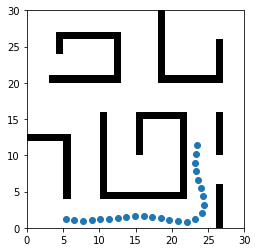

In [7]:
# Visualize random data sample
i = np.random.randint(1,numEntries)
plt.imshow(mapImg, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.scatter(data[i, :-dim:dim] * gridSize, data[i, 1:-dim:dim] * gridSize)
plt.show()

In [6]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain, dim * nPreviousStates:-dim+1:] # states [x,y,yaw,steer] to predict
X_test = data[numTrain:numEntries, dim * nPreviousStates:-dim+1:]

numTest = X_test.shape[0]

print(X_train.shape)

(65800, 96)


In [7]:
# generate conditioning variable

prevStates = data[:, :nPreviousStates*dim]
nextStates = data[:, nPreviousStates*dim:-dim+1]
nextStates = data[:, nPreviousStates*dim:-dim+1]
goalState = data[:, -dim+1:]

prevStatesConditions = data[:, :nPreviousStates * dim]
goalStateCondition = data[:, -dim+1:]

cs = np.concatenate((prevStatesConditions, goalStateCondition), axis=1)

c_dim = cs.shape[1]
c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(82251, 7)


In [24]:
# define planning problem

def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


class MyNNStateSampler(ob.StateSampler):
    def __init__(self, space):
         super(MyNNStateSampler, self).__init__(space)
         self.name_ = "my sampler"
         self.bounds = space.getBounds()

    def sampleUniform(self, state):
        global sampledStates

        if np.random.uniform() < pStates:
            # Use a CVAE state:
            sampleInd = np.random.randint(low=0, high=numSamples-1)
            stateInd = np.random.randint(low=0, high=nDrawnSamples)
            rndState = predictedStates[sampleInd, stateInd*dim:(stateInd+1)*dim]
        else:
            rndState = [np.random.uniform(low=self.bounds.low[0], high=self.bounds.high[0]),
                        np.random.uniform(low=self.bounds.low[1], high=self.bounds.high[1]),
                        np.random.uniform(low=-np.pi, high=np.pi)]

        state.setX(float(rndState[0]))
        state.setY(float(rndState[1]))
        state.setYaw(float(rndState[2]))

        sampledStates = np.vstack((sampledStates, np.array([[state.getX(),
                                                         state.getY(), 
                                                         state.getYaw()]])))


class MyNNControlSampler(oc.ControlSampler):
    def __init__(self, cspace):
        super(MyNNControlSampler, self).__init__(cspace)
        self.name = "my sampler"
        self.cbounds = cspace.getBounds()

    def sampleNext(self, control, previous, state):
        global nDrawnCtrl
        nDrawnCtrl += 1

        currentState = np.array([state.getX(), state.getY(), state.getYaw(), previous[0]])
        stateNorm = np.linalg.norm(predictedStates.reshape(numSamples, nDrawnSamples, dim) - currentState, axis=2)

        if np.random.uniform() < pControl and np.min(stateNorm) < 0.1:
            # Use a CVAE control input
            # Use the control input from the predicted states/inputs that are nearest (Eucl.) the current state

            nearestInd = np.argwhere(stateNorm == np.min(stateNorm)).reshape(-1)
            nearestState = predictedStates[nearestInd[0], nearestInd[1]*dim:(nearestInd[1]+1)*dim]
            delta = nearestState[-1]
            
            control[0] = float(delta)

        else:
            control[0] = float(np.random.uniform(low=self.cbounds.low[0], high=self.cbounds.high[0]))


def allocNNStateSampler(space):
    return MyNNStateSampler(space)


def allocNNControlSampler(cspace):
    return MyNNControlSampler(cspace)


def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return inflatedGrid[v,u] > 0


def propagate(start, control, duration, state):
    global exploredStates

    state.setX(start.getX() + v * duration * np.cos(start.getYaw()))
    state.setY(start.getY() + v * duration * np.sin(start.getYaw()))
    state.setYaw(start.getYaw() + v / L * np.tan(control[0]) * duration)

    exploredStates = np.vstack((exploredStates, np.array([[start.getX() + v * duration * np.cos(start.getYaw()), 
                                                            start.getY() + v * duration * np.sin(start.getYaw()), 
                                                            start.getYaw() + v / L * np.tan(control[0]) * duration]])))


def problemDef():
    # construct the state space we are planning in
    space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # create a control space
    cspace = oc.RealVectorControlSpace(space, 1)

    # set the bounds for the control space
    cbounds = ob.RealVectorBounds(1)
    cbounds.setLow(-1.3)
    cbounds.setHigh(1.3)
    cspace.setBounds(cbounds)

    ss = oc.SimpleSetup(cspace)
    ss.setStatePropagator(oc.StatePropagatorFn(propagate))
    # set state and control sampler
    cspace.setControlSamplerAllocator(oc.ControlSamplerAllocator(allocNNControlSampler))
    space.setStateSamplerAllocator(ob.StateSamplerAllocator(allocNNStateSampler))

    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))

    si = ss.getSpaceInformation()
    si.setPropagationStepSize(.4)
    si.setMaxControlDuration(1)
    si.setMinControlDuration(1)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))

    planner = oc.RRT(si)
    ss.setPlanner(planner)

    return ss


def plan(planObj, initState, goalState):

    space = ob.SE2StateSpace()
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(40.0)
    exactSolTerminationCondition = ob.exactSolnPlannerTerminationCondition(planObj.getProblemDefinition())
    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), epsilon=0.02)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

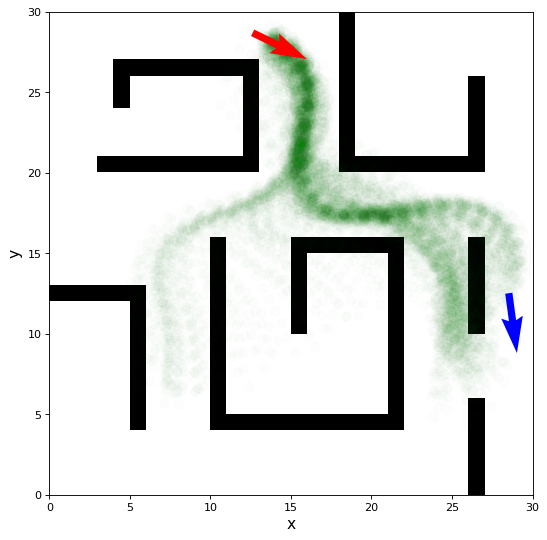

In [71]:
# compare performance of planning w/ and w/out the learned distributions

numSamples = 400 # number of drawn CVAE samples (/)per time step)
nMaps = 1 # number of test maps
nTestsPerMap = 1 # number of tests per test map

pStates = 0.0 # likelihood which to sample from NN state samples
pControl = 0.0 # likelihood which to sample from NN control samples
v = 0.1
L = 0.2 # vehicle length constant
minCostThreshold = 0.0 # set minimumcost threshold to only attempt complex planning scenarios

pdef = problemDef()
nSampledStates = np.zeros(shape=(nMaps,nTestsPerMap))

#planIdxs = np.random.choice(np.arange(numTrain, numEntries-1), nMaps, replace=False)

plotPaths = True
for i, planIdx in enumerate(planIdxs):
    for j in range(nTestsPerMap):
        exploredStates = np.zeros(shape=(1, 3))

        sampledStates = np.zeros(shape=(1, 3))

        start = data[planIdx, :dim] # x, y, yaw, steer
        trueGoal = data[planIdx, -dim+1:] # x, y, yaw ('true' goal)
        goal = data[planIdx, -2*dim+1:-dim] # goal as the final state in true predicted states (intermediate goal)

        c = torch.from_numpy(np.repeat([np.append(start, trueGoal)],numSamples,axis=0)).float().to(DEVICE)
        predictedStates = network(torch.randn(numSamples, z_dim).to(DEVICE), c, encode=False).cpu().detach().numpy()

        pdef.clear()
        nDrawnCtrl = 0
        plan(pdef, initState=start, goalState=goal)

        if pdef.getProblemDefinition().hasExactSolution():

            sol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))
            nSampledStates[i, j] = sampledStates.shape[0] - 1

            if plotPaths:
                plt.imshow(occGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
                plt.quiver(sol[:, 0] * gridSize, sol[:, 1] * gridSize, np.cos(sol[:,2]), np.sin(sol[:,2]), color="purple", scale=8.0, width=0.015, alpha=0.9)
                plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
                plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
                plt.show()

fig1 = plt.figure(figsize=(8,8), dpi=80)
plt.scatter(predictedStates[:,::dim] * gridSize, predictedStates[:,1::dim] * gridSize, color='green', s=70, alpha=0.01, label='CVA predicted ($p_x$, $p_y$) states') # nn samples
plt.imshow(mapImg, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
plt.xlabel('$p_x [-]$', fontsize=14)
plt.ylabel('$p_y [-]$', fontsize=14)
leg = plt.legend(loc='lower left')
for lh in leg.legendHandles:
    if not lh.get_alpha() is None:
        lh.set_alpha(1)
plt.show()

In [69]:
print('Mean num sampled states/map: {}, std: {}'.format(np.mean(nSampledStates, axis=1), np.std(nSampledStates, axis=1)))
# print('Mean num sampled states: {}, std: {}'.format(np.mean(nSampledStates), np.std(nSampledStates)))
print(nSampledStates)

#nSamplesNoNN = nSampledStates
#nSamplesNNStates = nSampledStates
#nSamplesNNStatesControl = nSampledStates

# [ 8898.9  4465.7 18092.8 10553.7 15218.9], std: [17066.62018356  3479.11557871 21600.45421652  9517.69245195 10302.65682676]
# [ 832.8  910.2 2648.6 3067.4 2925.5], std: [ 385.71460952  819.32384318  991.47054419 2412.48731396 1421.08446266]
# [ 937.1 1742.2 3219.8 2883.3 2292.8], std: [ 341.30966878  989.28871418 1508.81415688 2028.83326323 1267.98042572]


Mean num sampled states/map: [28368.], std: [0.]
[[28368.]]


In [ ]:
# create plots for nSampledStates with varying pStates and pControl

fig = plt.figure(figsize=(8,8))
plt.errorbar(np.arange(nMaps) - 0.1, np.mean(nSamplesNoNN, axis=1), np.std(nSamplesNoNN, axis=1), color='C0', fmt='o', ecolor='k', label='$\lambda_s$=0, $\lambda_y$=0')
plt.errorbar(np.arange(nMaps), np.mean(nSamplesNNStates, axis=1), np.std(nSamplesNNStates, axis=1), color='orangered', fmt='o', ecolor='k', label='$\lambda_s$=0.6, $\lambda_y$=0')
plt.errorbar(np.arange(nMaps) + 0.1, np.mean(nSamplesNNStatesControl, axis=1), np.std(nSamplesNNStatesControl, axis=1), color='purple', fmt='o', ecolor='k', label='$\lambda_s$=0.6, $\lambda_y$=0.6')
plt.xlabel('Map a) planning scenario No.', fontsize=14)
plt.ylabel('# drawn samples', fontsize=14)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.show()

(29916, 3)
(29916, 3)
saving animation


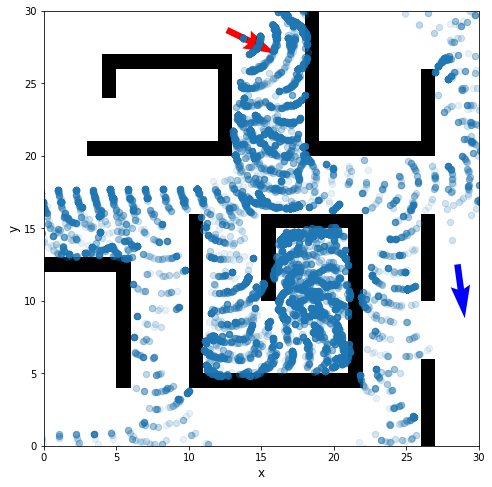

In [70]:
# animate explored states
uniqueExploredStates = exploredStates[np.sort(np.unique(exploredStates, axis=0, return_index=True)[1])]
print(exploredStates.shape)
print(uniqueExploredStates.shape)

dist = np.linalg.norm(np.diff(uniqueExploredStates[:,:2], axis=0), axis=1)
plotIdx = np.where(np.abs(dist - 0.1) < 0.1)[0]
numframes = 400
assert plotIdx.shape[0] >= numframes
plotIdx = plotIdx[::plotIdx.shape[0]//numframes]

def update_plot(i):
    scat = plt.scatter(x[plotIdx[i]:plotIdx[i+1]] * gridSize, y[plotIdx[i]:plotIdx[i+1]] * gridSize, color='C0', s=40, alpha=0.1)
    return scat

numframes = plotIdx.shape[0] - 1
x, y = uniqueExploredStates[:,0], uniqueExploredStates[:,1]

fig = plt.figure(figsize=(8,8))
plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
plt.xlim([0, gridSize])
plt.ylim([0, gridSize])
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes))

print("saving animation")                            
ani.save('animation.mp4', fps=5)